In [22]:
import pdb
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
import random
from pymoo.operators.selection.tournament import TournamentSelection
from problem import MyProblem
from mutation import MyMutation
from crossover import TraceCrossover
from mock_tools import MockEncoder, MockDeclare4Py
from sampling import MySampling
from callback import UpdatePopulationCallback
from growingGA import GrowingNSGA2, PreSurvivalNSGA2
import numpy as np
from tools import Tools
from survival import MySurvival
from pymoo.operators.crossover.sbx import SBX
from Declare4Py.ProcessModels.DeclareModel import DeclareModel
from Declare4Py.ProcessModels.DeclareModel import DeclareModelTemplate
from Declare4Py.D4PyEventLog import D4PyEventLog
import warnings
import random
from datetime import datetime, timedelta
from Declare4Py.ProcessMiningTasks.ConformanceChecking.MPDeclareResultsBrowser import MPDeclareResultsBrowser
from Declare4Py.ProcessMiningTasks.ConformanceChecking.MPDeclareAnalyzer import MPDeclareAnalyzer
import os
import pandas as pd
import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)
warnings.filterwarnings("ignore", ".*feasible.*")

# n_events = 5-10-15-20
# n_activities = 5-10-15-20-25-30

activities_name = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T"]
# TODO check the feature ranges
variable_boundaries = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
timestamps = Tools.generate_random_timestamps(len(activities_name))
case_concept_name = ['1'] * len(activities_name)

data = {
    'case:concept:name': case_concept_name,
    'concept:name': activities_name,
    'timestamp': timestamps,
}

dataframe = pd.DataFrame(data)


dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])


encoder = MockEncoder(activities_name)
declare = DeclareModel().parse_from_file("base_model.decl")
model_constraints = declare.get_decl_model_constraints()

event_log = D4PyEventLog()
event_log.log = dataframe

# TODO make some info
event_log.timestamp_key = "timestamp"
event_log.activity_key = "concept:name"

event_log.to_eventlog()

basic_checker = MPDeclareAnalyzer(log=event_log, declare_model=declare, consider_vacuity=False)
conf_check_res: MPDeclareResultsBrowser = basic_checker.run()

print(conf_check_res.get_metric(trace_id=0, metric="num_activations"))
print("-------------------------------------------")

# d4py = MockDeclare4Py()

[None, None, None, 1, 1, 1]
-------------------------------------------


In [23]:
from terminator import MyTermination
from pymoo.termination import get_termination

# create random pop
n_traces = 10
trace_length = 20

initial_population = [[random.choice(activities_name) for _ in range(trace_length)] for _ in range(n_traces)]
initial_encoded_pop = [encoder.encode(trace) for trace in initial_population]
features_range = Tools.calculate_feature_range(initial_encoded_pop, variable_boundaries)
lower_bounds = [x[0] for x in features_range]
upper_bounds = [x[1] for x in features_range]

print(initial_population)
print(initial_encoded_pop)

# instantiate problem objectives
mutation = MyMutation(feature_range=features_range)
crossover = TraceCrossover(variable_boundaries=variable_boundaries)
sampling = MySampling(initial_population=initial_encoded_pop)
pop_size = 2000
survival = MySurvival(n_children_survive=50)

termination = MyTermination(10)
# termination = get_termination("n_gen", 10)


[['G', 'G', 'F', 'J', 'C', 'I', 'F', 'M', 'S', 'J', 'F', 'O', 'M', 'C', 'L', 'T', 'L', 'H', 'A', 'R'], ['T', 'F', 'O', 'T', 'E', 'J', 'M', 'E', 'K', 'K', 'I', 'A', 'E', 'G', 'I', 'G', 'A', 'B', 'B', 'O'], ['J', 'H', 'Q', 'D', 'C', 'T', 'E', 'G', 'F', 'A', 'N', 'F', 'F', 'O', 'K', 'B', 'O', 'T', 'Q', 'L'], ['J', 'S', 'E', 'R', 'T', 'Q', 'B', 'H', 'D', 'O', 'P', 'H', 'Q', 'K', 'D', 'J', 'E', 'I', 'N', 'I'], ['D', 'A', 'A', 'L', 'Q', 'F', 'B', 'K', 'F', 'B', 'B', 'A', 'I', 'H', 'A', 'J', 'P', 'T', 'P', 'K'], ['S', 'C', 'G', 'F', 'L', 'C', 'L', 'E', 'L', 'G', 'O', 'M', 'O', 'L', 'T', 'S', 'C', 'H', 'H', 'D'], ['H', 'C', 'J', 'Q', 'L', 'C', 'D', 'S', 'T', 'L', 'H', 'R', 'J', 'J', 'D', 'F', 'N', 'G', 'O', 'E'], ['G', 'C', 'N', 'C', 'M', 'E', 'S', 'H', 'J', 'I', 'T', 'Q', 'S', 'P', 'M', 'D', 'D', 'L', 'O', 'P'], ['M', 'G', 'S', 'K', 'E', 'I', 'K', 'G', 'T', 'B', 'M', 'I', 'K', 'D', 'E', 'G', 'L', 'P', 'K', 'S'], ['B', 'B', 'O', 'E', 'O', 'P', 'Q', 'G', 'I', 'I', 'T', 'E', 'J', 'D', 'K', 'H', 

In [24]:


problem = MyProblem(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=0)

algorithm = NSGA2(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    eliminate_duplicates=False,
)


result = minimize(problem, algorithm, termination=termination, seed=1, verbose=True)

G = np.array([individual.G for individual in result.pop])
traces = [individual.X.tolist() for individual in result.pop]

# Print the feasible traces
for i, (trace, g) in enumerate(zip(traces, G)):
    if g == 0:
        decoded_trace =  encoder.decode(trace)

        dataframe['concept:name'] = pd.DataFrame(decoded_trace)
        event_log.log = dataframe
        event_log.to_eventlog()

        basic_checker = MPDeclareAnalyzer(log=event_log, declare_model=declare, consider_vacuity=False)
        conf_check_res: MPDeclareResultsBrowser = basic_checker.run()
        print(f"Feasible Trace {i + 1}: {trace}")

        print("Solution Decoded:", encoder.decode(trace))
        print(conf_check_res.get_metric(trace_id=0, metric="num_violations"))
        print("-------------------------------------------")
#
# print("Best Solution Encoded:", result.X)
# print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
# print("Objective Values:", result.F)
# print("Constraint Values:", result.G)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       10 |      1 |  0.3333333333 |  0.6000000000 |             - |             -
     2 |     2010 |      1 |  0.1666666667 |  0.5630000000 |             - |             -
     3 |     4010 |      1 |  0.1666666667 |  0.4338333333 |             - |             -
     4 |     6010 |      1 |  0.000000E+00 |  0.3740000000 |             - |             -
     5 |     8010 |      2 |  0.000000E+00 |  0.3035000000 |  0.2000000000 |         ideal
     6 |    10010 |      1 |  0.000000E+00 |  0.2810833333 |  0.5000000000 |         ideal
Feasible Trace 1: [1, 1, 3, 4, 14, 2, 6, 9, 13, 7, 10, 6, 9, 2, 15, 7, 10, 14, 16, 6]
Solution Decoded: ['B', 'B', 'D', 'E', 'O', 'C', 'G', 'J', 'N', 'H', 'K', 'G', 'J', 'C', 'P', 'H', 'K', 'O', 'Q', 'G']
[None, None, None, 0, 0, 0]
-------------------------------------------
Feasible Trace 2: [8, 8, 10, 10, 11, 2, 1, 13, 7, 1, 17, 15, 15, 3, 4, 13, 2, 15, 10, 

cv_min = smallest constraint violation

cv_avg = average constraint violation

eps = Epsilon Improvement, improvement of the pareto front from iter to iter


init pop = 10
population = 2000
iter = 20


avg of 28.5 sec with only satisfy score
avg of 29 sec with both satisfy score and violation score



n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |  0.3333333333 |  0.6000000000 |             - |             -


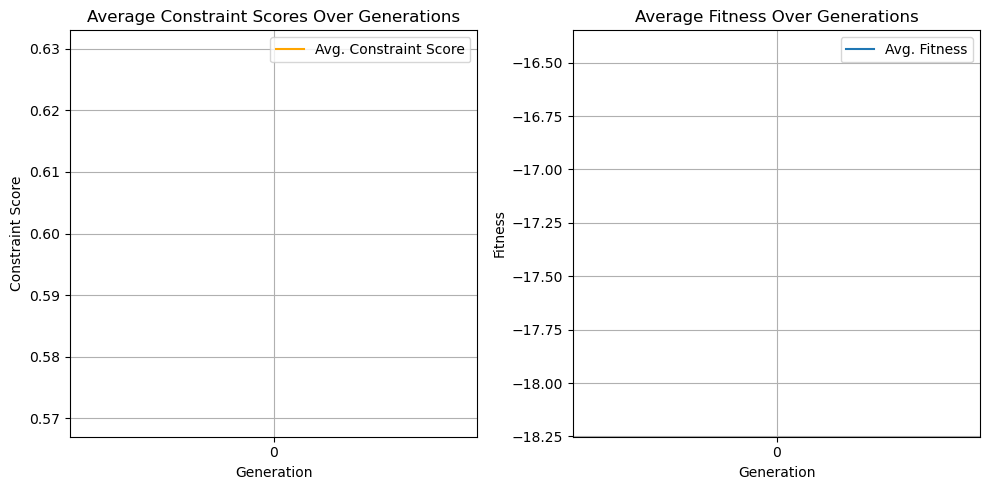

     2 |     2010 |  0.000000E+00 |  0.5602500000 | -1.720000E+01 | -1.720000E+01


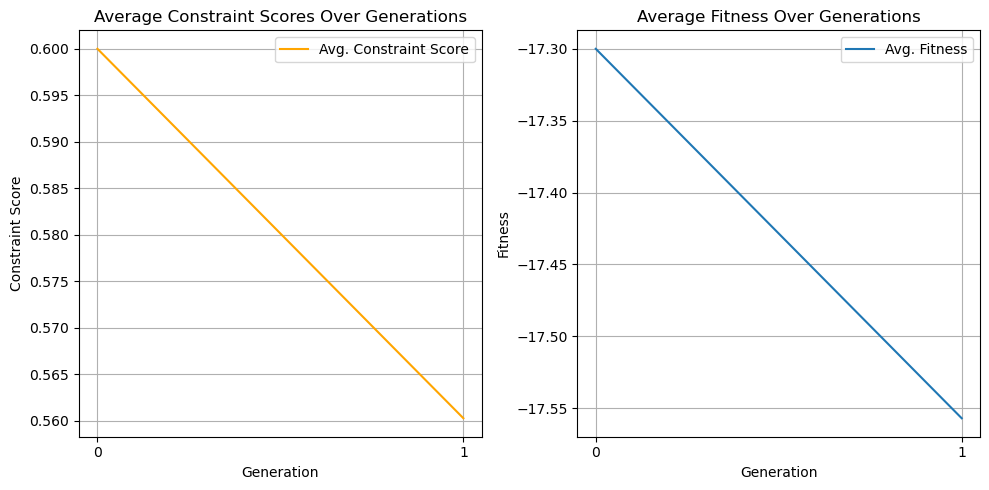

     3 |     4010 |  0.000000E+00 |  0.4268333333 | -1.758000E+01 | -1.790000E+01


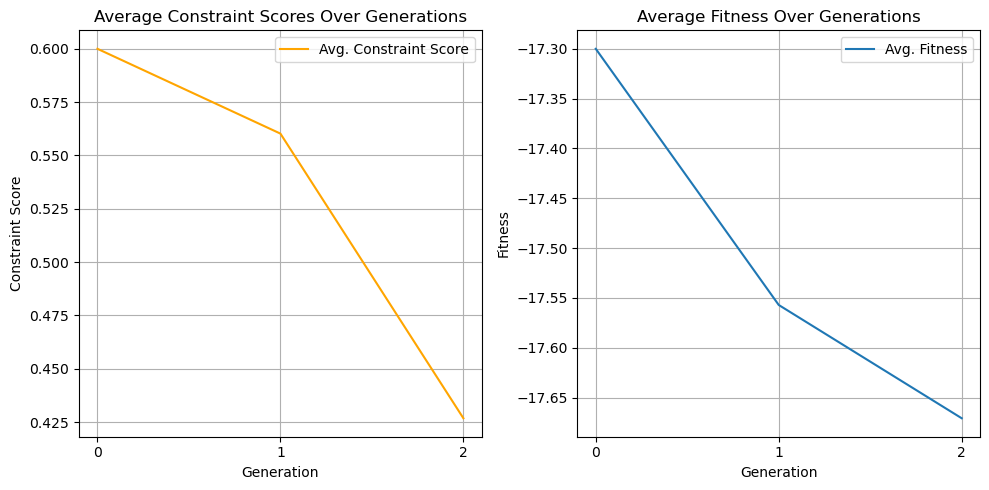

     4 |     6010 |  0.000000E+00 |  0.3626666667 | -1.763750E+01 | -1.800000E+01


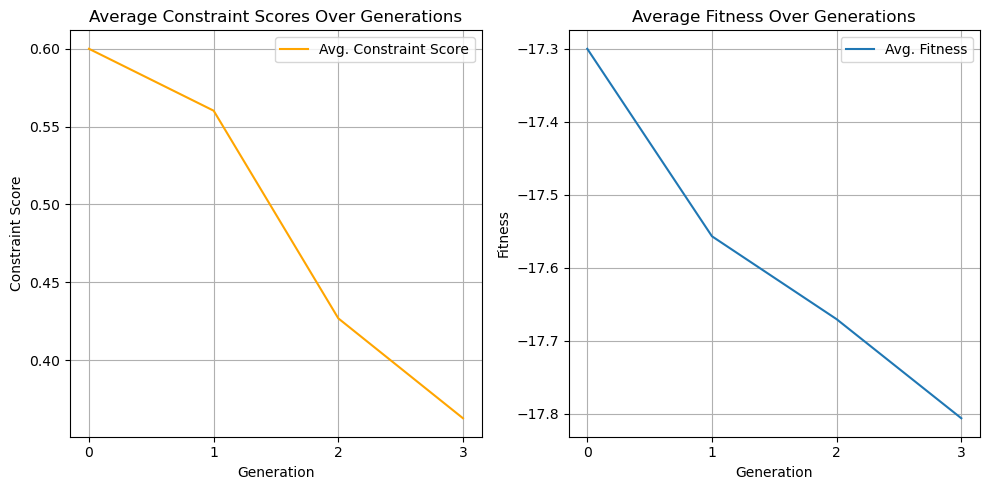

     5 |     8010 |  0.000000E+00 |  0.2970000000 | -1.763750E+01 | -1.800000E+01


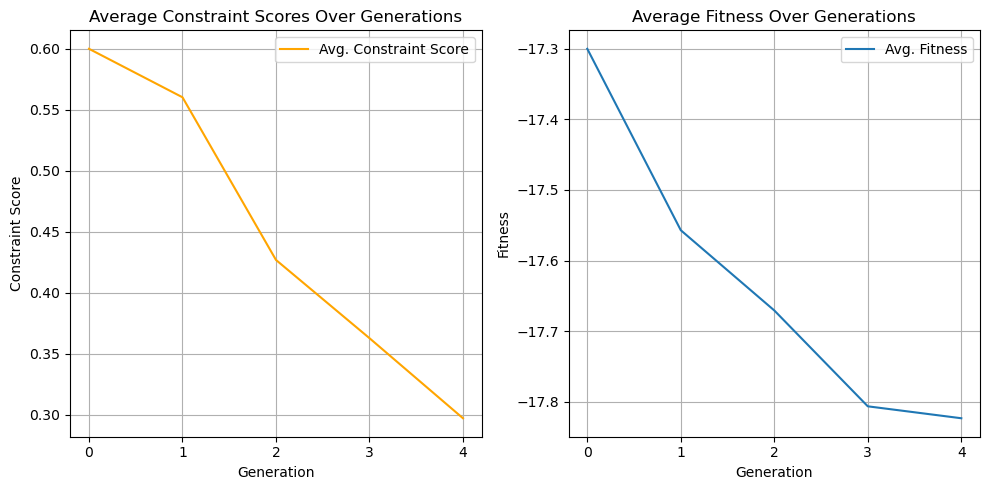

     6 |    10010 |  0.000000E+00 |  0.2700833333 | -1.788000E+01 | -1.880000E+01


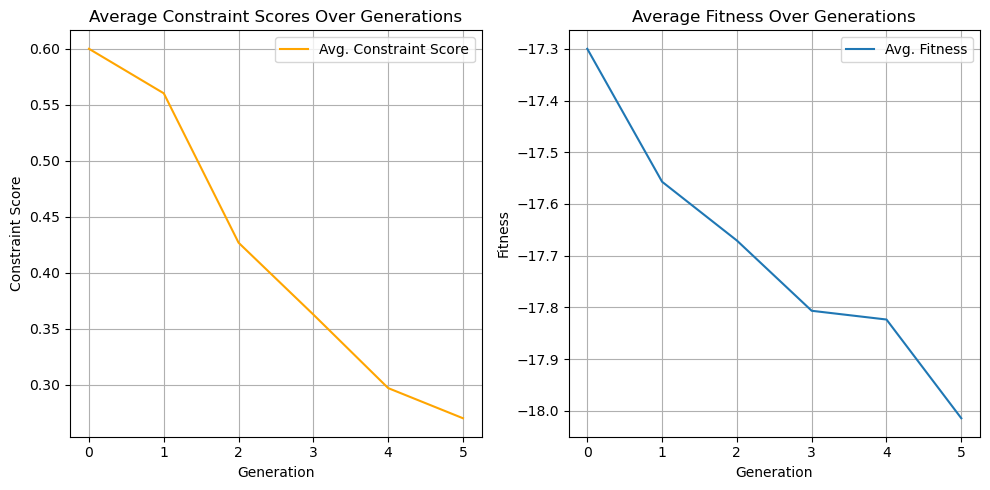

Feasible Trace 1: [1, 2, 1, 13, 7, 2, 8, 16, 6, 7, 14, 14, 17, 9, 14, 13, 13, 10, 3, 4]
Feasible Trace 2: [1, 12, 12, 10, 4, 6, 10, 10, 7, 1, 12, 2, 17, 3, 4, 2, 12, 16, 10, 7]
Feasible Trace 3: [5, 11, 1, 2, 4, 6, 10, 16, 14, 1, 12, 8, 6, 3, 4, 10, 11, 15, 2, 8]
Feasible Trace 4: [1, 6, 18, 7, 18, 12, 14, 6, 19, 5, 7, 1, 18, 3, 4, 6, 2, 7, 2, 6]
Feasible Trace 5: [1, 12, 17, 12, 2, 8, 2, 8, 19, 1, 15, 13, 6, 3, 4, 6, 12, 19, 10, 18]
Feasible Trace 6: [1, 6, 18, 17, 4, 18, 9, 13, 19, 1, 12, 2, 14, 3, 4, 2, 11, 12, 16, 9]
Feasible Trace 7: [18, 6, 1, 19, 19, 2, 9, 8, 8, 1, 12, 8, 11, 3, 4, 6, 2, 15, 9, 9]
Feasible Trace 8: [17, 6, 1, 19, 19, 2, 9, 8, 19, 1, 12, 8, 11, 3, 4, 6, 2, 15, 9, 18]
Feasible Trace 9: [1, 11, 16, 3, 4, 18, 2, 6, 9, 1, 12, 8, 10, 3, 4, 6, 12, 10, 2, 18]
Feasible Trace 10: [1, 6, 18, 10, 4, 9, 6, 6, 18, 1, 1, 2, 10, 3, 4, 10, 11, 2, 4, 12]
Feasible Trace 11: [9, 11, 1, 10, 2, 6, 10, 6, 9, 1, 6, 8, 10, 3, 4, 8, 2, 6, 10, 8]
Feasible Trace 12: [1, 11, 18, 16, 2, 8, 6

In [25]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from problem import MyProblem2


problem = MyProblem2(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=1)

algorithm = GA(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    eliminate_duplicates=False,
)


result = minimize(problem, algorithm, termination=termination, seed=1, verbose=True)

G = np.array([individual.G for individual in result.pop])
traces = [individual.X.tolist() for individual in result.pop]

# Print the feasible traces
for i, (trace, g) in enumerate(zip(traces, G)):
    if g == 0:
        print(f"Feasible Trace {i + 1}: {trace}")

print("Best Solution Encoded:", result.X)
# print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)
print("Constraint Values:", result.G)


only few millisecond faster than the 2 obj algorithm

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       10 |      1 |  0.3333333333 |  0.6000000000 |             - |             -


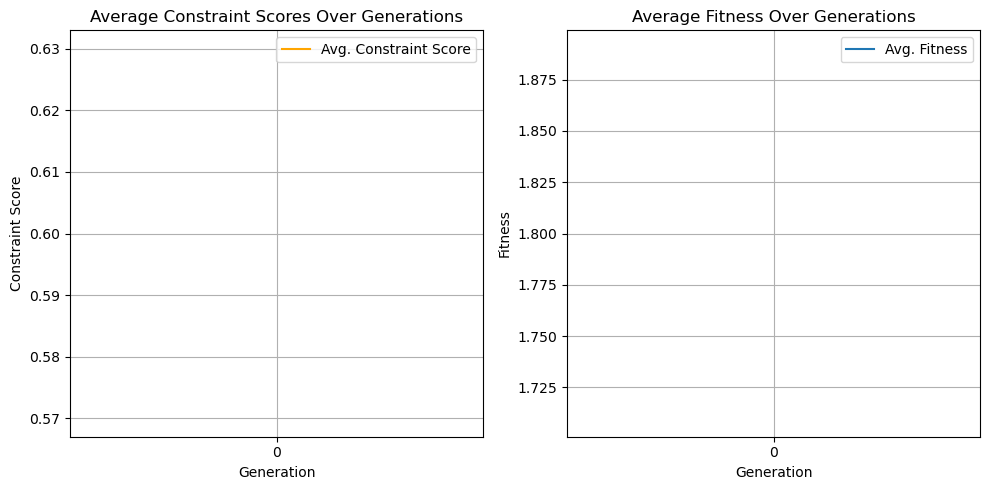

     2 |     2010 |      1 |  0.1666666667 |  0.5630000000 |             - |             -


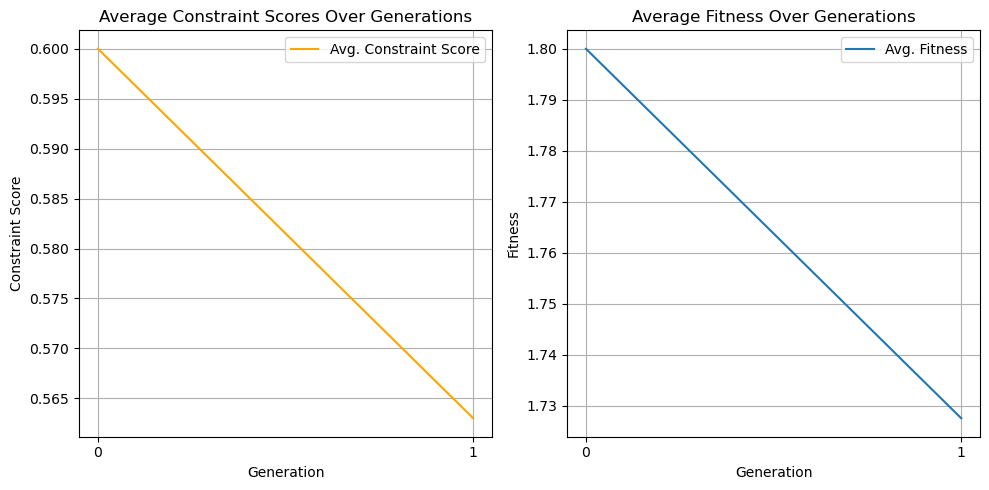

     3 |     4010 |      1 |  0.1666666667 |  0.4338333333 |             - |             -


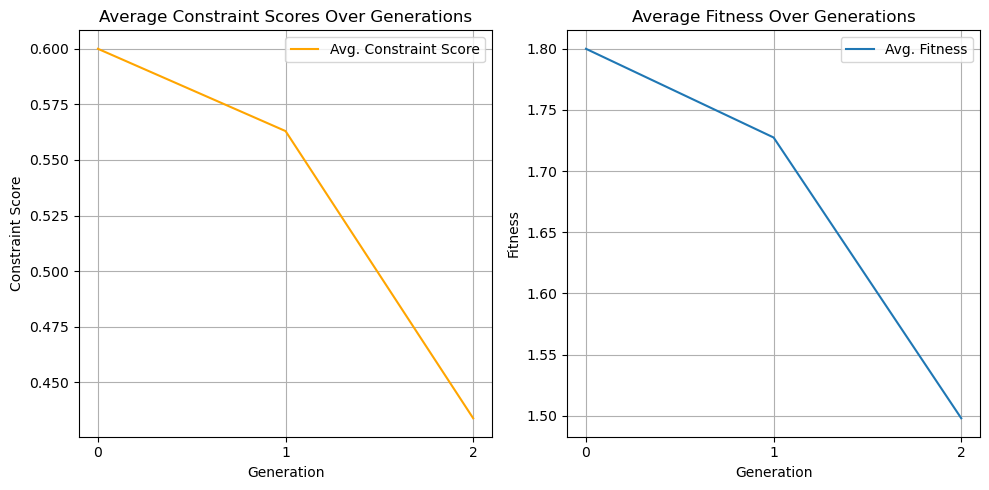

     4 |     6010 |      1 |  0.000000E+00 |  0.3740000000 |             - |             -


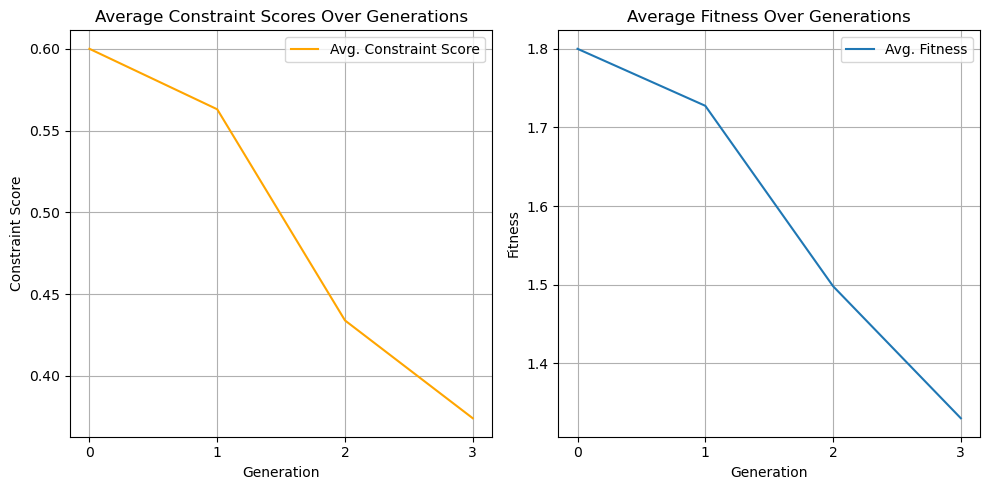

     5 |     8010 |      2 |  0.000000E+00 |  0.3035000000 |  0.2000000000 |         ideal


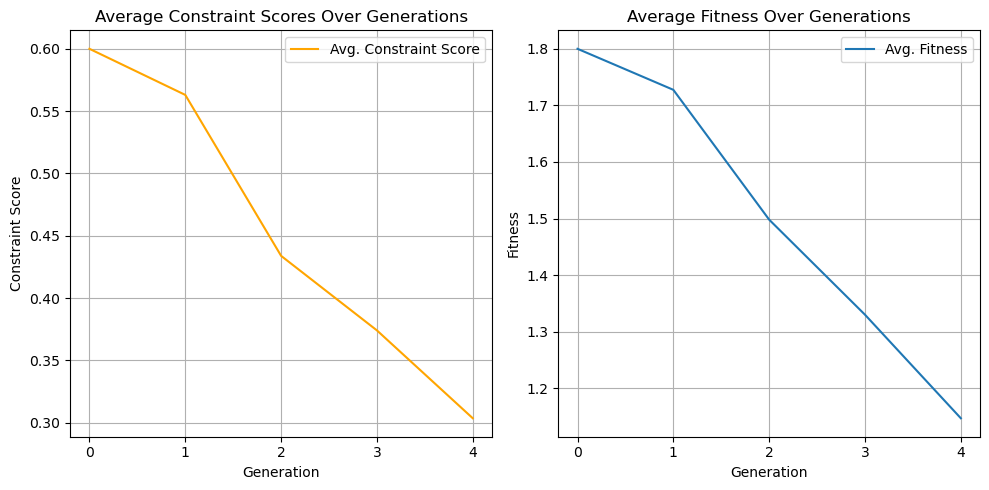

     6 |    10010 |      1 |  0.000000E+00 |  0.2810833333 |  0.5000000000 |         ideal


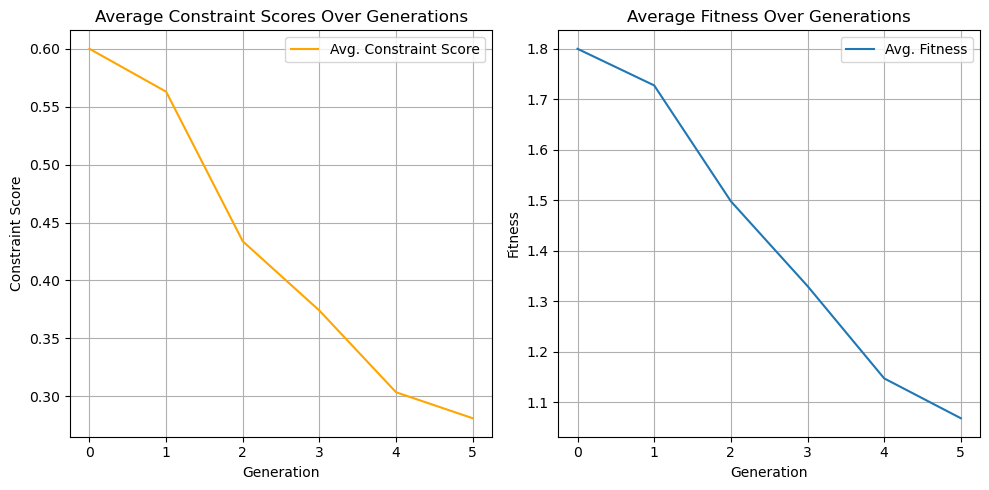

Best Solution Encoded: [[ 1  1  3  4 14  2  6  9 13  7 10  6  9  2 15  7 10 14 16  6]]
Best Solution Decoded: [['B', 'B', 'D', 'E', 'O', 'C', 'G', 'J', 'N', 'H', 'K', 'G', 'J', 'C', 'P', 'H', 'K', 'O', 'Q', 'G']]
Objective Values: [[  0.  -18.8]]
Constraint Values: [[0.]]


In [26]:
from problem import MyProblem_Problem


problem = MyProblem_Problem(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=1)


algorithm = NSGA2(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    eliminate_duplicates=False,
)

result = minimize(problem, algorithm, termination=termination, seed=1, verbose=True)


print("Best Solution Encoded:", result.X)
print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)
print("Constraint Values:", result.G)

Seems a little slower than with ElementalWise problem object

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       10 |  0.3333333333 |  0.6000000000 |             - |             -


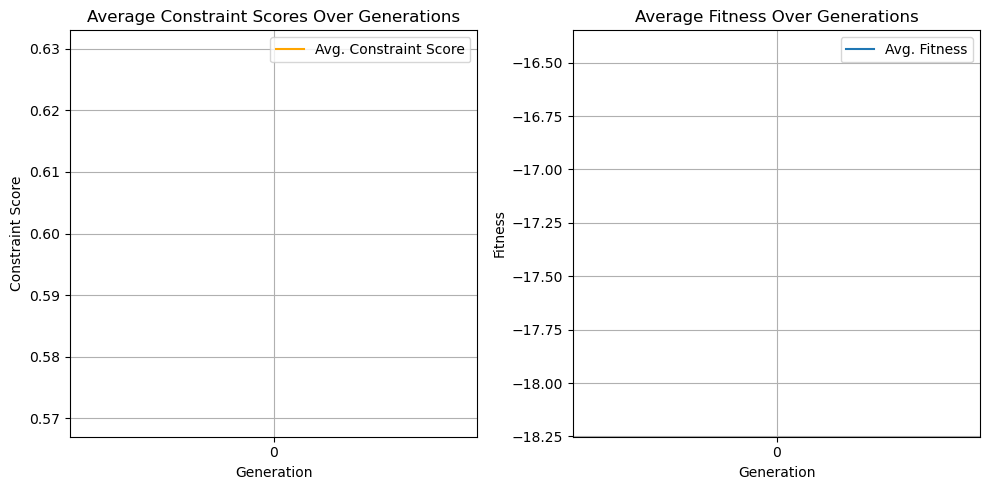

     2 |     2010 |  0.000000E+00 |  0.5602500000 | -1.720000E+01 | -1.720000E+01


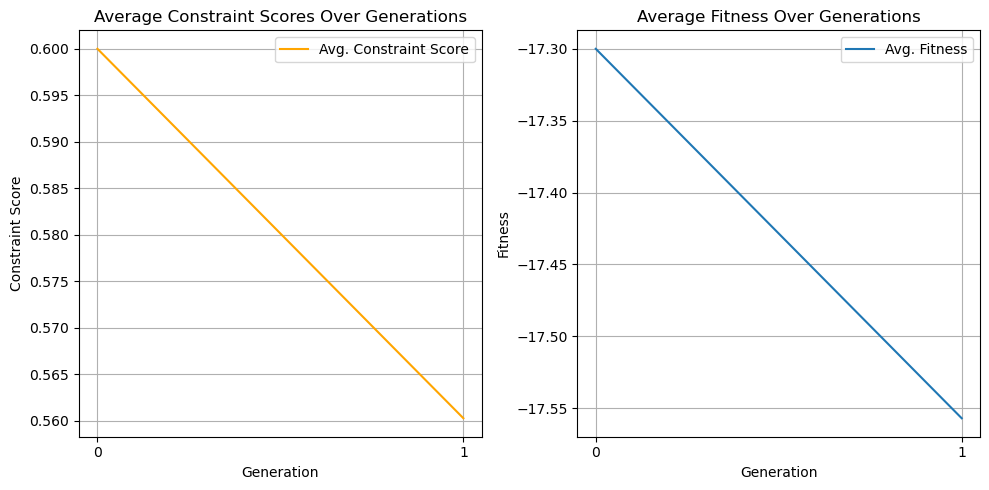

     3 |     4010 |  0.000000E+00 |  0.4268333333 | -1.758000E+01 | -1.790000E+01


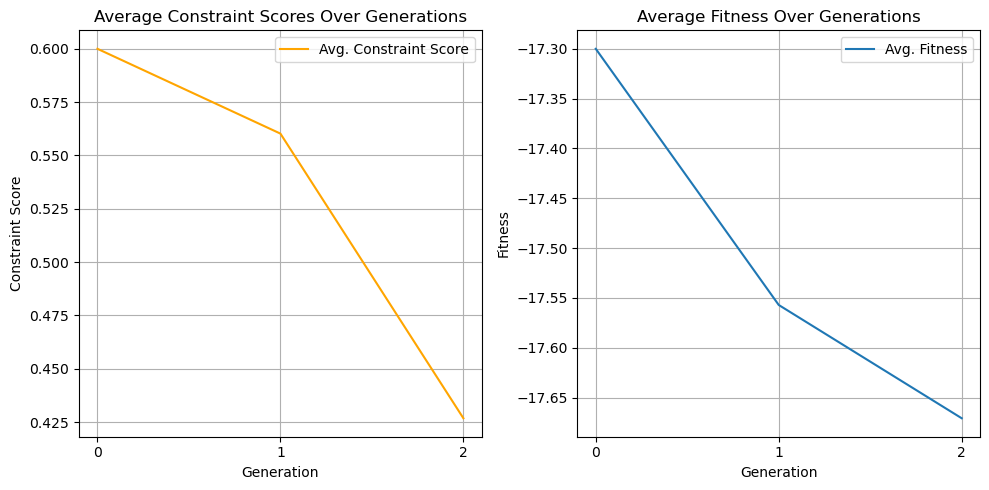

     4 |     6010 |  0.000000E+00 |  0.3626666667 | -1.763750E+01 | -1.800000E+01


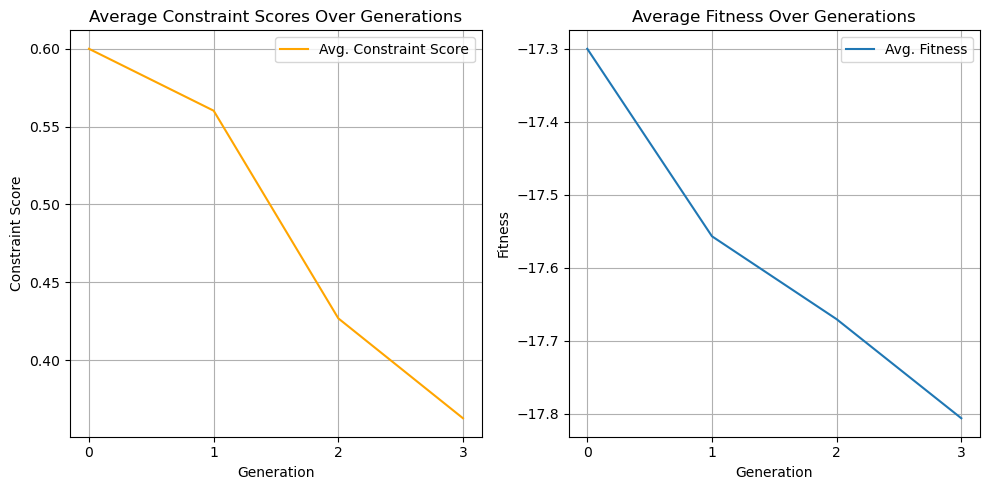

     5 |     8010 |  0.000000E+00 |  0.2970000000 | -1.763750E+01 | -1.800000E+01


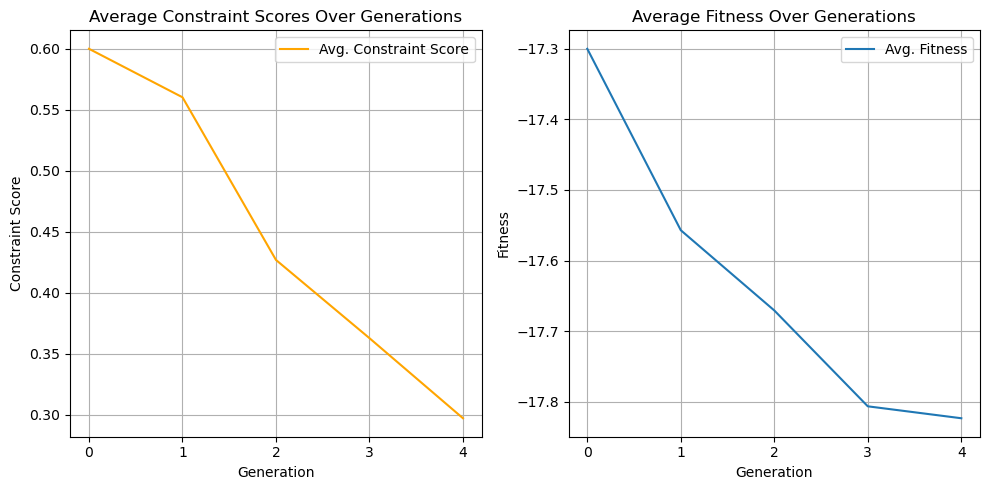

     6 |    10010 |  0.000000E+00 |  0.2700833333 | -1.788000E+01 | -1.880000E+01


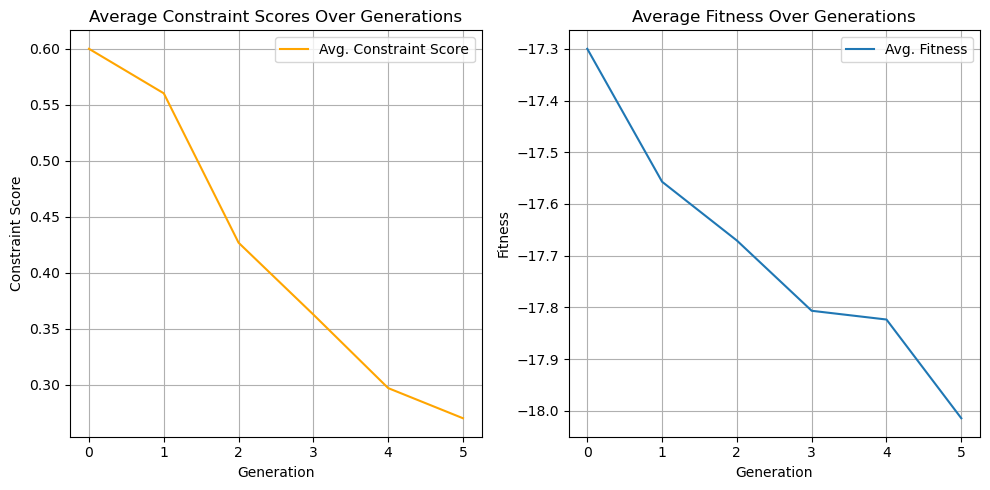

Best Solution Encoded: [ 1  2  1 13  7  2  8 16  6  7 14 14 17  9 14 13 13 10  3  4]
Objective Values: [-18.8]
Constraint Values: [0.]


In [27]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from problem import MyProblem_Problem2


problem = MyProblem_Problem2(
    trace_length=trace_length,
    encoder=encoder,
    d4py=declare,
    initial_population=initial_encoded_pop,
    xl=lower_bounds,xu=upper_bounds,
    event_log=event_log,
    dataframe=dataframe
)

callback = UpdatePopulationCallback(problem=problem, plot=1)

algorithm = GA(
    problem=problem,
    pop_size=pop_size,
    sampling=sampling,
    crossover=crossover,
    mutation=mutation,
    callback=callback,
    eliminate_duplicates=False,
)

result = minimize(problem, algorithm, termination=termination, seed=1, verbose=True)

print("Best Solution Encoded:", result.X)
# print("Best Solution Decoded:", [encoder.decode(solution) for solution in result.X])
print("Objective Values:", result.F)
print("Constraint Values:", result.G)
